# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [1]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

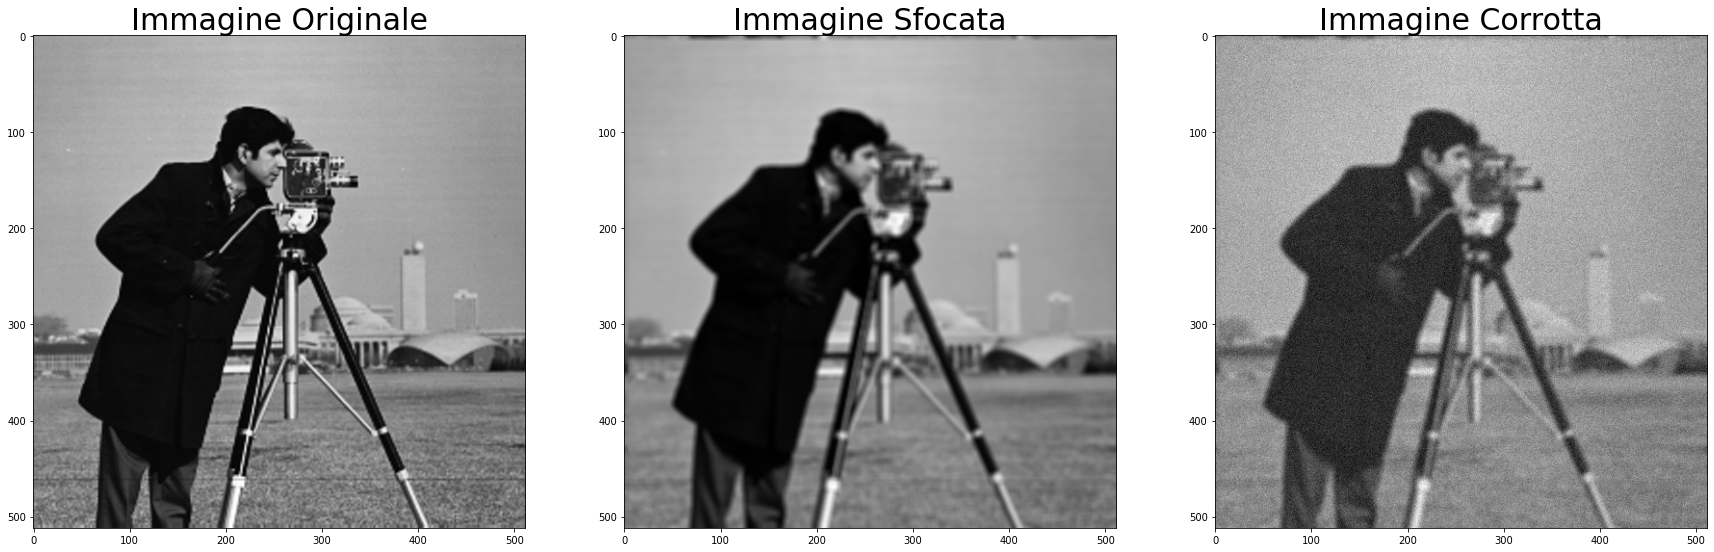

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1 data.camera()
X = data.camera()
m, n = X.shape
x = X.reshape(m*n)


# 2
X_blur = A(X)
x_blur = X_blur.reshape(m*n)


# 3
# Generiamo il rumore eta
sigma = 0.1# Varianza del rumore
eta = np.random.normal(size=X_blur.shape)
eta /= np.linalg.norm(eta, 'fro')
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [3]:
maxit=50
stop=1e-6

def find_x(error):
  return np.where(error == np.amin(error))[0]

def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, error)
  plt.title(title)
  plt.grid()
  plt.show()

def f(x,b):
  return 0.5*(np.linalg.norm(A(x)-b))**2

def Fgrad(x,b):
  return AT(A(x)-b)

def Falpha(x,b,grad,f): #calcola alpha

  alpha=1.1
  rho=0.5
  c=0.25
  i=0

  while np.linalg.norm(f(x+alpha*grad,b)) <= np.linalg.norm(f(x,b)+alpha*c*np.dot(Fgrad(x,b).T,grad)) and alpha<1e-5: 
    alpha *= rho
    i += 1
  
  return alpha;

def minimize(x0,b,maxit,stop,xTrue):
  x=x0
  grad=Fgrad(b,x)
  err=np.zeros(maxit)
  i=0

  while (np.linalg.norm(grad)>stop) and (i<maxit) :
    x=x + Falpha(x,b,grad,f)*(-grad)
    grad=Fgrad(x,b)
    err[i]=np.linalg.norm(xTrue-x)
    i=i+1

  err[:i]
  return err,i,x


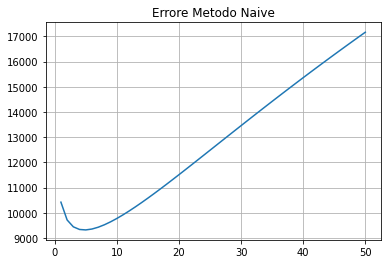

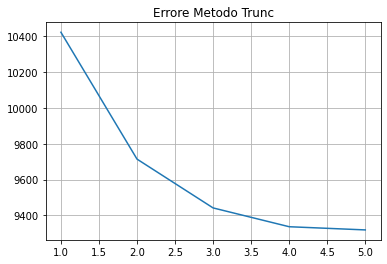

Text(0.5, 1.0, 'Immagine a semi convergenza')

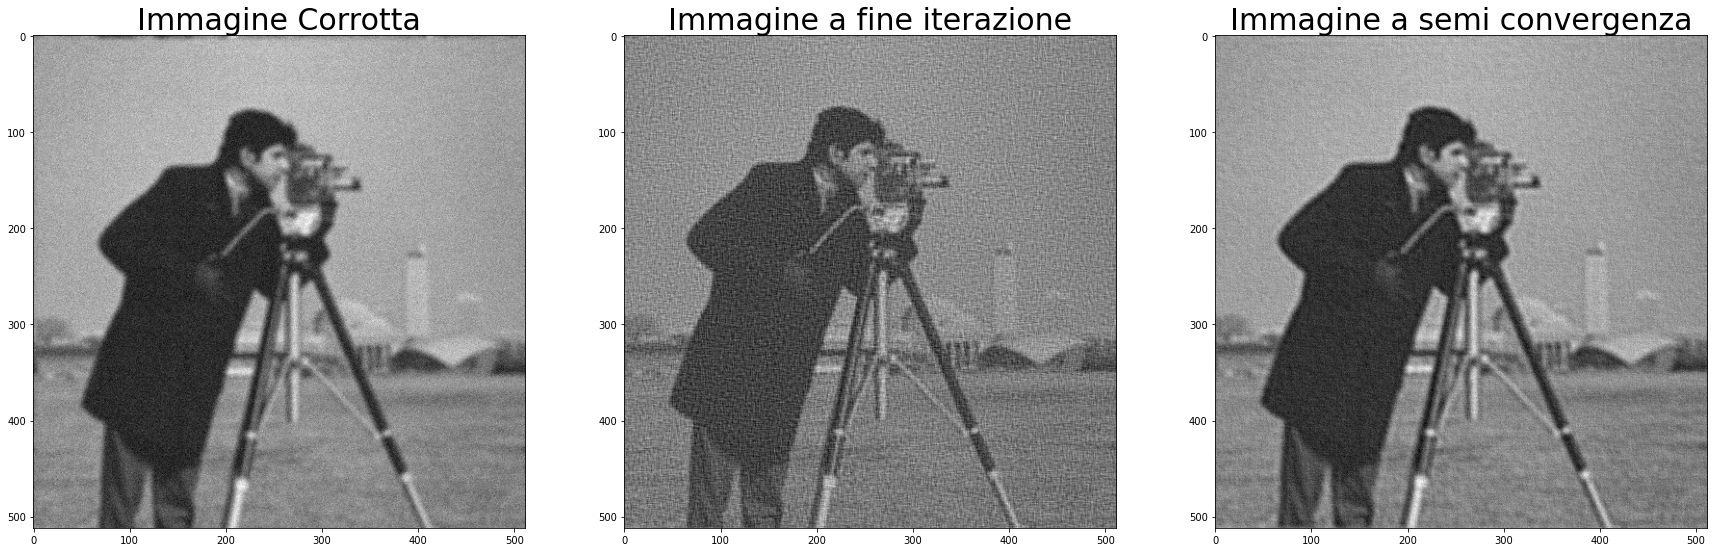

In [4]:
err_naive,i_naive,x_naive=minimize(B,B,maxit,stop,X)
plot(i_naive,err_naive,'Errore Metodo Naive')

Semiconv=find_x(err_naive)
err_trunc,i_trunc,x_trunc=minimize(B,B,Semiconv+1,stop,X)
plot(i_trunc,err_trunc,'Errore Metodo Trunc')

plt.figure(figsize=(30,10))

ax3 = plt.subplot(1, 3, 1)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

ax1 = plt.subplot(1,3, 2)
ax1.imshow(x_naive, cmap='gray')
plt.title('Immagine a fine iterazione', fontsize=30)

ax2 = plt.subplot(1,3, 3)
ax2.imshow(x_trunc, cmap='gray')
plt.title('Immagine a semi convergenza', fontsize=30)

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [5]:
from operator import itemgetter

def f_reg(x,b,lamb):
  return 0.5 * np.linalg.norm(A(x)-b,ord=2)**2 + lamb *0.5 * np.linalg.norm(x,ord=2)**2

def Fgrad_reg(x,b,lamb):
  return AT(A(x)-b) + lamb*x

def Falpha_reg(x,b,grad,f,lamb): #calcola alpha

  alpha=1.1
  rho=0.5
  c=0.25
  i=0

  while np.linalg.norm(f_reg(x+alpha*grad,b,lamb)) <= np.linalg.norm(f_reg(x,b,lamb)+alpha*c*np.dot(Fgrad_reg(x,b,lamb).T,grad)) and alpha<1e-5:
    alpha *= rho
    i += 1
  
  return alpha;

def minimize_reg(x0,b,maxit,stop,xTrue,lamb):
  x=x0
  grad=Fgrad_reg(x,b,lamb)
  err=np.zeros(maxit)
  i=0

  while (np.linalg.norm(grad)>stop) and (i<maxit) :
    x=x + Falpha_reg(x,b,grad,f,lamb)*(-grad)
    grad=Fgrad_reg(x,b,lamb)
    err[i]=np.linalg.norm(xTrue-x)
    i=i+1

  err[:i]
  indexMin=find_x(err)
  MinErr=err[indexMin]
  return err,i,x

def LambdaEuristico(x0,b,maxit):
  lamb=1e-2
  err=np.zeros(maxit)
  i=0

  while i<10: #controllo per 10 lambda
    err[i],_,_=minimize_reg(B,B,maxit,stop,X,lamb) #in questo algoritmo, minimize_reg ritornava MinErr
    print("Err",i,' ',err[i])
    lamb=lamb*1.3
    print(lamb)
    i+=1

  err[:i]
  index=find_x(err) #trovo a che indice otteniamo l'errore minore
  return lamb*1.3**(index+1)  #restituisco il valore di lambda a l'errore[index]

def LambdaDiscrepanza(b,maxit):
  lamb=0.030
  err,_,x=minimize_reg(B,B,maxit,stop,X,lamb)
  x_i=find_x(err)
  _,_,x=minimize_reg(B,B,maxit,stop,X,lamb)

  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb*=1.1
    err,_,x=minimize_reg(B,B,maxit,stop,X,lamb)
    x_i=find_x(err)
    _,_,x=minimize_reg(B,B,x_i+1,stop,X,lamb)

  return lamb/1.1

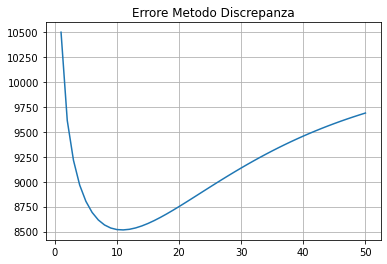

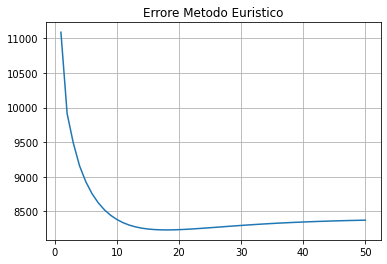

In [6]:
#lambdaE=LambdaEuristico(B,B,maxit) #lambdaE=0.06274851700000002

lambdaE=0.06274851700000002
lamb=0.031000000000000003 #lambda Discrepanza
err_lambdaE,i_lambdaE,x_E=minimize_reg(B,B,maxit,stop,X,lambdaE)
err_lambdaDis,i_lambdaDis,x_Discrepanza=minimize_reg(B,B,maxit,stop,X,lamb)
plot(i_lambdaDis,err_lambdaDis,'Errore Metodo Discrepanza')
plot(i_lambdaE,err_lambdaE,'Errore Metodo Euristico')


indexDis=find_x(err_lambdaDis)
indexE=find_x(err_lambdaE)
_,_,x_Dis=minimize_reg(B,B,indexDis+1,stop,X,lamb)
_,_,x_E=minimize_reg(B,B,indexE+1,stop,X,lambdaE)

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [7]:
def f_reg1(x,b,lamb):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)

def Fgrad_reg1(x,b,lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def Falpha_reg1(x,b,grad,f,lamb): #calcola alpha

  alpha=1.1
  rho=0.5
  c=0.25
  i=0

  while np.linalg.norm(f_reg1(x+alpha*grad,b,lamb)) <= np.linalg.norm(f_reg1(x,b,lamb)+alpha*c*np.dot(Fgrad_reg1(x,b,lamb).T,grad)) and alpha<1e-5:
    alpha *= rho
    i += 1
  
  return alpha;

def minimize_reg1(x0,b,maxit,stop,xTrue,lamb):
  x=x0
  grad=Fgrad_reg1(x,b,lamb)
  err=np.zeros(maxit)
  i=0

  while (np.linalg.norm(grad)>stop) and (i<maxit) :
    x=x + Falpha_reg1(x,b,grad,f,lamb)*(-grad)
    grad=Fgrad_reg1(x,b,lamb)
    err[i]=np.linalg.norm(xTrue-x)
    i=i+1

  err=err[:i]
  return err,i,x

def LambdaDiscrepanza1(b,maxit):
  lamb=0.031
  err,_,x=minimize_reg1(B,B,maxit,stop,X,lamb)
  x_i=find_x(err)
  _,_,x=minimize_reg1(B,B,maxit,stop,X,lamb)

  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb*=1.3
    err,_,x=minimize_reg1(B,B,maxit,stop,X,lamb)
    x_i=find_x(err)
    _,_,x=minimize_reg1(B,B,x_i+1,stop,X,lamb)

  return lamb/1.3

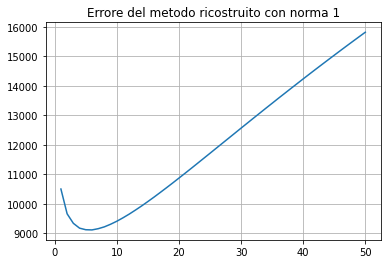

[9115.73608648]


In [8]:
lamb1 =3.486227616 #lamda tramite condizione discrepanza con LambdaDiscrepanza1
(err_reg1,i_reg1,x_reg1) = minimize_reg1(B,B,maxit,stop,X,lamb1)
plot(i_reg1, err_reg1,"Errore del metodo ricostruito con norma 1")

index1 = find_x(err_reg1)
print(err_reg1[index1])
_,_,X1= minimize_reg1(B,B,index1+1,stop,X,lamb1)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [9]:
def f_regM(x,b,lamb,mu):
  return 0.5*np.linalg.norm(A(x)-b)**2 + 0.5*lamb*np.linalg.norm(x,2)**2 + mu*np.linalg.norm(x,1)

def Fgrad_regM(x,b,lamb,mu):
  return AT(A(x)-b) + lamb*x+mu*np.sign(x)

def Falpha_regM(x,b,grad,f,lamb,mu): #calcola alpha

  alpha=1.1
  rho=0.5
  c=0.25
  i=0

  while np.linalg.norm(f_regM(x+alpha*grad,b,lamb,mu)) <= np.linalg.norm(f_regM(x,b,lamb,mu)+alpha*c*np.dot(Fgrad_regM(x,b,lamb,mu).T,grad)) and alpha<1e-5:
    alpha *= rho
    i += 1
  
  return alpha;

def minimize_regM(x0,b,maxit,stop,xTrue,lamb,mu):
  x=x0
  grad=Fgrad_regM(x,b,lamb,mu)
  err=np.zeros(maxit)
  i=0

  while (np.linalg.norm(grad)>stop) and (i<maxit) :
    x=x + Falpha_regM(x,b,grad,f,lamb,mu)*(-grad)
    grad=Fgrad_regM(x,b,lamb,mu)
    err[i]=np.linalg.norm(xTrue-x)
    i=i+1

  err=err[:i]
  return err,i,x

def LambdaDiscrepanzaM(b,maxit,mu):
  lamb=0.02
  err,_,x=minimize_regM(B,B,maxit,stop,X,lamb,mu)
  x_i=find_x(err)
  _,_,x=minimize_regM(B,B,maxit,stop,X,lamb,mu)

  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb*=1.1
    err,_,x=minimize_regM(B,B,maxit,stop,X,lamb,mu)
    x_i=find_x(err)
    _,_,x=minimize_regM(B,B,x_i+1,stop,X,lamb,mu)

  return lamb/1.1

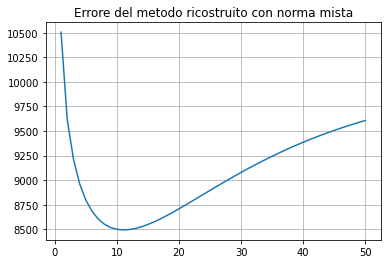

[8494.7691754]


In [10]:
mu = 0.1
lambM =0.029282000000000006 #lamda tramite condizione discrepanza LambdaDiscrepanzaM

(err_reg_mista,ite_reg_mista,x_reg_mista,) = minimize_regM(B,B,maxit,stop,X,lamb,mu)
plot(ite_reg_mista, err_reg_mista,"Errore del metodo ricostruito con norma mista")
X_reg_mista = find_x(err_reg_mista)
print(err_reg_mista[X_reg_mista])
_,_,x_mista=minimize_regM(B,B,X_reg_mista+1,stop,X,lamb,mu)

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


In [11]:
def error(xTrue,x):
  return np.linalg.norm(x-xTrue)/np.linalg.norm(xTrue)

def psnr(xTrue,x):
  return 20 * np.log10(np.max(x) / ((1 / xTrue.size) * np.linalg.norm(eta)))

print("ErroreCorrotta=",error(X,B))
print("Errorex_naive=",error(X,x_naive))
print("Errorex_trunc=",error(X,x_trunc))
print("Errorex_E=",error(X,x_E))
print("Errorex_Dis=",error(X,x_Dis))
print("ErroreX1=",error(X,X1))
print("Errorex_mista=",error(X,x_mista))

print('\n')

print("PSNRCorrotta=",psnr(X,B))
print("PSNRx_naive=",psnr(X,x_naive))
print("PSNRx_trunc=",psnr(X,x_trunc))
print("PSNRx_E=",psnr(X,x_E))
print("PSNRx_Dis=",psnr(X,x_Dis))
print("PSNRX1=",psnr(X,X1))
print("PSNRx_mista=",psnr(X,x_mista))

plt.figure(figsize=(100, 100))

ax1 = plt.subplot(3, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize= 40)

ax2 = plt.subplot(3,3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=40)

ax3 = plt.subplot(3,3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=40)

ax4 = plt.subplot(3,3, 4)
ax4.imshow(x_naive, cmap='gray')
plt.title('Immagine Naive', fontsize=40)

ax5 = plt.subplot(3,3, 5)
ax5.imshow(x_trunc, cmap='gray')
plt.title('Immagine Semiconvergenza', fontsize=40)

ax6 = plt.subplot(3,3,6)
ax6.imshow(x_E, cmap='gray')
plt.title('Immagine Regolarizzata con metodo Euristico', fontsize=40)

ax7 = plt.subplot(3,3,7)
ax7.imshow(x_Dis, cmap='gray')
plt.title('Immagine Regolarizzata con discrepanza', fontsize=40)

ax8 = plt.subplot(3,3,8)
ax8.imshow(X1, cmap='gray')
plt.title('Immagine Regolarizzata con norma 1', fontsize=40)

ax9 = plt.subplot(3,3,9)
ax9.imshow(x_mista, cmap='gray')
plt.title('Immagine Regolarizzata con norma mista', fontsize=40)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.



In [12]:
img1=data.checkerboard()
img2=data.grass()
img3=data.page()

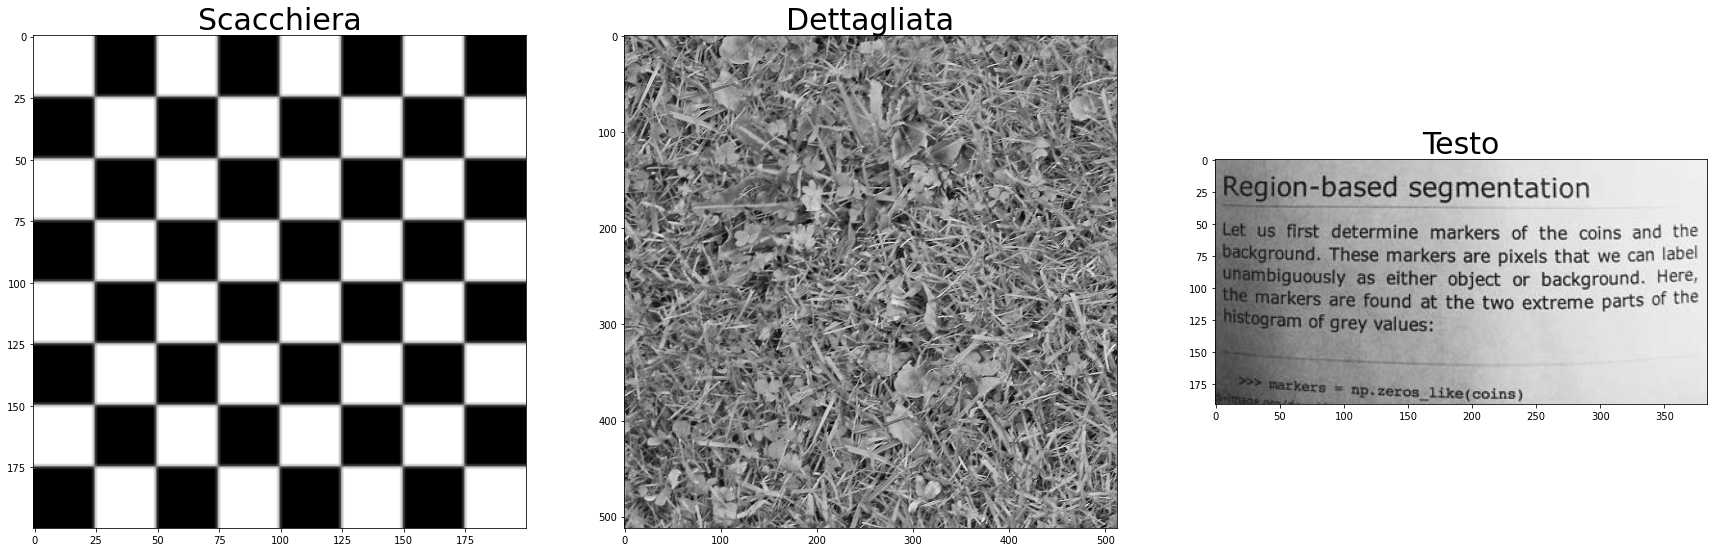

In [13]:
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(img1, cmap='gray')
plt.title('Scacchiera', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(img2, cmap='gray')
plt.title('Dettagliata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(img3, cmap='gray')
plt.title('Testo', fontsize=30)

plt.show()